In [1]:
from datasets import load_dataset

dataset_name = "bentrevett/multi30k"

dataset = load_dataset(dataset_name)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import math
import torch.nn.functional as F

In [4]:
from transformers import BertTokenizer

tokenizer_en = BertTokenizer.from_pretrained('bert-base-uncased') # 영어 토큰화
tokenizer_de = BertTokenizer.from_pretrained('bert-base-german-cased') # 독일어 토큰화

class Dataset(Dataset):
    def __init__(self, data, tokenizer_en, tokenizer_de, device):
        self.data = data
        self.tokenizer_en = tokenizer_en
        self.tokenizer_de = tokenizer_de
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        en_text = self.data['en'][idx]
        de_text = self.data['de'][idx]

        en_encoded = tokenizer_en.encode(en_text, add_special_tokens=True)
        de_encoded = tokenizer_de.encode(de_text, add_special_tokens=True)

        return {'en': torch.tensor(en_encoded).to(self.device), 'de': torch.tensor(de_encoded).to(self.device)}

device = torch.device('mps')

def collate_fn(batch):
    src_batch = [text['de'] for text in batch]
    trg_batch = [text['en'] for text in batch]

    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=tokenizer_de.pad_token_id)
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=tokenizer_en.pad_token_id)

    return {'src': src_padded, 'trg': trg_padded}

train_dataset = Dataset(dataset['train'], tokenizer_en, tokenizer_de, device)
valid_dataset = Dataset(dataset['validation'], tokenizer_en, tokenizer_de, device)
test_dataset = Dataset(dataset['test'], tokenizer_en, tokenizer_de, device)

# DataLoader 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False, drop_last=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [6]:
for i, batch in enumerate(train_loader):
    src = batch['src']
    trg = batch['trg']

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [seq_num, seq_len]

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([32, 28])
인덱스 0: 3
인덱스 1: 2779
인덱스 2: 1075
인덱스 3: 2
인덱스 4: 678
인덱스 5: 4916
인덱스 6: 42
인덱스 7: 39
인덱스 8: 10828
인덱스 9: 2
인덱스 10: 287
인덱스 11: 115
인덱스 12: 297
인덱스 13: 10494
인덱스 14: 26914
인덱스 15: 4
인덱스 16: 0
인덱스 17: 0
인덱스 18: 0
인덱스 19: 0
인덱스 20: 0
인덱스 21: 0
인덱스 22: 0
인덱스 23: 0
인덱스 24: 0
인덱스 25: 0
인덱스 26: 0
인덱스 27: 0


In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)

        attention = torch.softmax(energy, dim=-1) # head_dim 차원에 softmax 적용 => attention score를 정규화

        x = torch.matmul(self.dropout(attention), V)

        x = x.permute(0, 2, 1, 3).contiguous()  # 연속적인 메모리로 재배열 (view 함수 쓰기 전 사용 필요)

        x = x.view(batch_size, -1, self.hidden_dim)

        x = self.fc_o(x)

        return x, attention

In [8]:
class FeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, ff_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, ff_dim)
        self.fc_2 = nn.Linear(ff_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        x = self.dropout(F.gelu(self.fc_1(x)))

        x = self.fc_2(x)

        return x

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, ff_dim, dropout_ratio, device):
        super().__init__()

        self.attn_layer_norm = nn.LayerNorm(hidden_dim) # hidden_dim 차원 정규화
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttention(hidden_dim, n_heads, dropout_ratio, device)
        self.feedforward = FeedforwardLayer(hidden_dim, ff_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src, src_mask):
        _src, attention = self.self_attention(src, src, src, src_mask)

        src = self.attn_layer_norm(src+self.dropout(_src))

        _src = self.feedforward(src)

        src = self.ff_layer_norm(src+self.dropout(_src))

        return src

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, device):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.device = device

    def forward(self, src):

        batch_size, src_len = src.shape[0], src.shape[1]
        pe = torch.zeros(src_len, self.hidden_dim).to(self.device)
        position = torch.arange(0, src_len).unsqueeze(1).to(self.device)
        div_term = torch.exp(torch.arange(0, self.hidden_dim, 2) * -(math.log(10000.0)/self.hidden_dim)).to(self.device)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).expand(batch_size, src_len, self.hidden_dim)

        return pe

In [11]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, n_heads, ff_dim, dropout_ratio, device, input_dim, n_layers):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = PositionalEncoding(hidden_dim, device)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, ff_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        src = self.dropout(self.tok_embedding(src)*self.scale + self.pos_embedding(src))

        for layer in self.layers:
            src = layer(src, src_mask)

        return src

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, ff_dim, dropout_ratio, device):
        super().__init__()

        self.attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)

        self.self_attention = MultiHeadAttention(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttention(hidden_dim, n_heads, dropout_ratio, device)
        self.feedforward = FeedforwardLayer(hidden_dim, ff_dim, dropout_ratio)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src, trg, src_mask, trg_mask):

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.attn_layer_norm(self.dropout(_trg) + trg)

        _trg, _ = self.encoder_attention(trg, src, src, src_mask)
        trg = self.enc_attn_layer_norm(self.dropout(_trg) + trg)

        _trg = self.feedforward(trg)
        trg = self.ff_layer_norm(self.feedforward(_trg) + trg)

        return trg

In [13]:
class Decoder(nn.Module):
    def __init__(self, hidden_dim, n_heads, ff_dim, dropout_ratio, device, output_dim, n_layers):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = PositionalEncoding(hidden_dim, device)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, ff_dim, dropout_ratio, device) for _ in range(n_layers)])
        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, trg, src_mask, trg_mask):

        trg = self.dropout(self.tok_embedding(trg)*self.scale + self.pos_embedding(trg))

        for layer in self.layers:
            trg = layer(src, trg, src_mask, trg_mask)

        output = self.fc_out(trg)

        return output

In [14]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        return src_mask

    def make_trg_mask(self, trg):

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2).to(self.device)

        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        trg_mask = trg_pad_mask & trg_sub_mask

        return trg_mask

    def forward(self, src, trg):

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        src = self.encoder(src, src_mask)
        output = self.decoder(src, trg, src_mask, trg_mask)

        return output

In [15]:
input_dim = tokenizer_de.vocab_size
output_dim = tokenizer_en.vocab_size
hidden_dim = 512
n_layers = 3
n_heads = 8
ff_dim = 512
dropout = 0.1

In [16]:
src_pad_idx = tokenizer_de.pad_token_id
trg_pad_idx = tokenizer_en.pad_token_id

encoder = Encoder(hidden_dim, n_heads, ff_dim, dropout, device, input_dim, n_layers)
decoder = Decoder(hidden_dim, n_heads, ff_dim, dropout, device, output_dim, n_layers)

model = Transformer(encoder, decoder, src_pad_idx, trg_pad_idx, device).to(device)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 59,267,898 trainable parameters


In [18]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(30000, 512)
    (pos_embedding): PositionalEncoding()
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttention(
          (fc_q): Linear(in_features=512, out_features=512, bias=True)
          (fc_k): Linear(in_features=512, out_features=512, bias=True)
          (fc_v): Linear(in_features=512, out_features=512, bias=True)
          (fc_o): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): FeedforwardLayer(
          (fc_1): Linear(in_features=512, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p

In [19]:
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup

optimizer = optim.AdamW(model.parameters(), lr=0.0005)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = trg_pad_idx)
total_steps = len(train_loader) * 15
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=2700,
    num_training_steps=total_steps
)

In [20]:
def train(model, iterator, optimizer, criterion, epoch, scheduler):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(tqdm(iterator, desc=f"Train Epoch {epoch+1}")):
        src = batch['src']
        trg = batch['trg']

        optimizer.zero_grad()

        output = model(src, trg[:, :-1])

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward()

        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [21]:
def evaluate(model, iterator, criterion, epoch):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(iterator, desc=f"Valid Epoch {epoch+1}")):

            src = batch['src']
            trg = batch['trg']

            output = model(src, trg[:,:-1])

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)

            trg = trg[:,1:].contiguous().view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [22]:
epochs = 15
clip = 1
best_valid_loss = float('inf')
model_save_path = "/Users/limbyeong-geuk/Desktop/7주차. Transformer_german_to_english.pt"

train_losses = []
valid_losses = []

for epoch in range(epochs):

    train_loss = train(model, train_loader, optimizer, criterion, epoch, scheduler)
    valid_loss = evaluate(model, valid_loader, criterion, epoch)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model saved!")

Valid Epoch 1: 100%|██████████| 31/31 [00:03<00:00,  8.57it/s]


Train Loss: 5.8211, Validation Loss: 3.8400
Best model saved!


Valid Epoch 2: 100%|██████████| 31/31 [00:03<00:00,  8.48it/s]


Train Loss: 3.1751, Validation Loss: 2.5403
Best model saved!


Valid Epoch 3: 100%|██████████| 31/31 [00:03<00:00,  8.60it/s]


Train Loss: 2.3332, Validation Loss: 2.1816
Best model saved!


Valid Epoch 4: 100%|██████████| 31/31 [00:03<00:00,  9.24it/s]


Train Loss: 1.9402, Validation Loss: 1.9257
Best model saved!


Valid Epoch 5: 100%|██████████| 31/31 [00:03<00:00,  8.95it/s]


Train Loss: 1.6154, Validation Loss: 1.8264
Best model saved!


Valid Epoch 6: 100%|██████████| 31/31 [00:03<00:00,  9.03it/s]


Train Loss: 1.3849, Validation Loss: 1.7514
Best model saved!


Valid Epoch 7: 100%|██████████| 31/31 [00:03<00:00, 10.26it/s]


Train Loss: 1.2013, Validation Loss: 1.7182
Best model saved!


Valid Epoch 8: 100%|██████████| 31/31 [00:03<00:00,  9.38it/s]


Train Loss: 1.0541, Validation Loss: 1.6970
Best model saved!


Valid Epoch 9: 100%|██████████| 31/31 [00:03<00:00,  9.98it/s]


Train Loss: 0.9202, Validation Loss: 1.7016


Valid Epoch 10: 100%|██████████| 31/31 [00:03<00:00, 10.08it/s]


Train Loss: 0.8101, Validation Loss: 1.6979


Valid Epoch 11: 100%|██████████| 31/31 [00:03<00:00, 10.08it/s]


Train Loss: 0.7052, Validation Loss: 1.7244


Valid Epoch 12: 100%|██████████| 31/31 [00:03<00:00,  9.86it/s]


Train Loss: 0.6156, Validation Loss: 1.7267


Valid Epoch 13: 100%|██████████| 31/31 [00:03<00:00,  9.60it/s]


Train Loss: 0.5375, Validation Loss: 1.7463


Valid Epoch 14: 100%|██████████| 31/31 [00:03<00:00,  9.91it/s]


Train Loss: 0.4722, Validation Loss: 1.7575


Valid Epoch 15: 100%|██████████| 31/31 [00:03<00:00,  9.95it/s]


Train Loss: 0.4224, Validation Loss: 1.7598


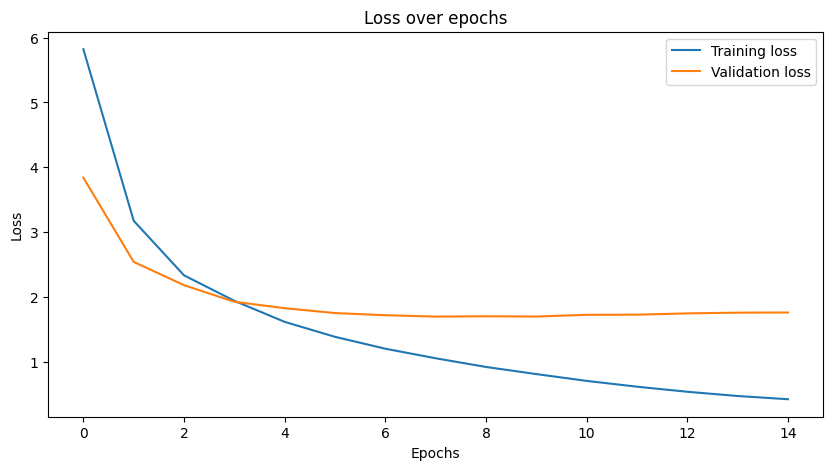

In [23]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, valid_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(train_losses, valid_losses)

In [24]:
def test(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(iterator)):

            src = batch['src']
            trg = batch['trg']

            output = model(src, trg[:,:-1])

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)

            trg = trg[:,1:].contiguous().view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [25]:
model_save_path = "/Users/limbyeong-geuk/Desktop/7주차. Transformer_german_to_english.pt"

model.load_state_dict(torch.load(model_save_path))

test_loss = test(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

100%|██████████| 31/31 [00:03<00:00,  9.35it/s]

Test Loss: 1.804 | Test PPL: 6.074


In [26]:
# 번역(translation) 함수
def translate_sentence(sentence, model, device, max_len=50):
    model.eval()

    tokens = tokenizer_de.encode(sentence, add_special_tokens=True)
    
    src_tensor = torch.tensor(tokens).unsqueeze(0).to(device)

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있게 하기
    trg_indexes = [tokenizer_en.cls_token_id]

    for i in range(max_len):

        trg = torch.tensor(trg_indexes).unsqueeze(0).to(device)
        
        trg_mask = model.make_trg_mask(trg)
        with torch.no_grad():
            output = model.decoder(src, trg, src_mask, trg_mask)

        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)
        
        # <eos>를 만나는 순간 종료
        if pred_token == tokenizer_en.sep_token_id:
            break

    trg_tokens = [tokenizer_en.decode(ids).replace(" ", "") for ids in trg_indexes]
    
    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:]

In [27]:
class TokenizedDataset(Dataset):
    def __init__(self, data, tokenizer_en, tokenizer_de):
        self.data = data
        self.tokenizer_en = tokenizer_en
        self.tokenizer_de = tokenizer_de

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        en_text = self.data['en'][idx]
        de_text = self.data['de'][idx]

        en_tokens = tokenizer_en.tokenize(en_text)
        de_tokens = tokenizer_de.tokenize(de_text)

        return {'en': en_tokens, 'de': de_tokens}

# 테스트 데이터셋 인스턴스 생성
tokenized_test_dataset = TokenizedDataset(dataset['test'], tokenizer_en, tokenizer_de)

In [28]:
example_idx = 10

src = tokenized_test_dataset[example_idx]['de']
trg = tokenized_test_dataset[example_idx]['en']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation = translate_sentence(src, model, device)

print("모델 출력 결과:", translation)

소스 문장: ['Eine', 'Mutter', 'und', 'ihr', 'kleiner', 'Sohn', 'genießen', 'einen', 'schönen', 'Tag', 'im', 'Freien', '.']
타겟 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
모델 출력 결과: ['a', 'mother', 'and', 'her', 'baby', 'son', 'enjoy', 'a', 'beautiful', 'day', '.', '[SEP]']


In [29]:
from torchtext.data.metrics import bleu_score

def show_bleu(data, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in tqdm(data):
        src = datum['de']
        trg = datum['en']

        pred_trg = translate_sentence(src, model, device, max_len)

        # 마지막 <eos> 토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f"Multiple Sentence score1 = {individual_bleu1_score*100:.2f}")
    print(f"Multiple Sentence score2 = {individual_bleu2_score*100:.2f}")
    print(f"Multiple Sentence score3 = {individual_bleu3_score*100:.2f}")
    print(f"Multiple Sentence score4 = {individual_bleu4_score*100:.2f}")

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}')
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}')
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}')
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}')

In [30]:
show_bleu(tokenized_test_dataset, model, device)

 10%|█         | 100/1000 [01:19<01:47,  8.39it/s]

[100/1000]
예측: ['a', 'group', 'of', 'asian', 'children', 'sit', 'in', 'work', 'chairs', '.']
정답: ['a', 'group', 'of', 'mostly', 'asian', 'children', 'sitting', 'at', 'cubic', '##les', 'in', 'blue', 'chairs', '.']


 20%|██        | 200/1000 [01:37<01:43,  7.76it/s]

[200/1000]
예측: ['all', 'of', 'all', 'standing', 'under', 'umbrella', '##s', '.']
정답: ['the', 'group', 'of', 'people', 'are', 'all', 'covered', 'by', 'umbrella', '##s', '.']


 30%|███       | 300/1000 [01:56<01:13,  9.48it/s]

[300/1000]
예측: ['a', 'goal', '##ie', 'in', 'a', 'yellow', 'jersey', 'is', 'coming', 'out', 'the', 'goal', '.']
정답: ['a', 'goal', '##ie', 'in', 'a', 'yellow', 'field', 'is', 'protecting', 'the', 'goal', '.']


 40%|████      | 400/1000 [02:12<00:57, 10.36it/s]

[400/1000]
예측: ['two', 'young', 'children', 'on', 'the', 'sand', '.']
정답: ['two', 'young', 'children', 'are', 'on', 'sand', '.']


 50%|█████     | 500/1000 [02:27<01:05,  7.64it/s]

[500/1000]
예측: ['two', 'medium', '-', 'sized', 'dogs', 'are', 'running', 'across', 'the', 'snow', '.']
정답: ['two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.']


 60%|██████    | 600/1000 [02:47<01:21,  4.92it/s]

[600/1000]
예측: ['a', 'group', 'of', 'men', 'sit', 'and', 'chatting', 'behind', 'green', 'fruit', '.']
정답: ['a', 'group', 'of', 'men', 'sitting', 'and', 'talking', 'behind', 'some', 'green', 'fruit', '.']


 70%|██████▉   | 699/1000 [03:10<00:47,  6.31it/s]

[700/1000]
예측: ['two', 'people', 'look', 'at', 'the', 'light', 'at', 'a', 'city', 'at', 'night', '.']
정답: ['two', 'people', 'look', 'on', 'in', 'the', 'nighttime', 'at', 'the', 'lights', 'in', 'a', 'city', '.']


 80%|████████  | 800/1000 [03:24<00:24,  8.17it/s]

[800/1000]
예측: ['people', 'all', 'of', 'people', 'all', 'all', 'all', 'wearing', 'bicycles', '.']
정답: ['crowds', 'of', 'people', 'are', 'all', 'riding', 'bicycles', '.']


 90%|█████████ | 900/1000 [03:40<00:14,  7.07it/s]

[900/1000]
예측: ['children', 'fight', 'to', 'tag', 'the', 'ball', '.']
정답: ['kids', 'compete', 'to', 'gain', 'possession', 'of', 'the', 'soccer', 'ball', '.']


100%|██████████| 1000/1000 [04:04<00:00,  4.08it/s]

[1000/1000]
예측: ['an', 'older', 'man', 'is', 'playing', 'a', 'video', 'game', '.']
정답: ['an', 'older', 'man', 'is', 'playing', 'a', 'video', 'arcade', 'game', '.']


Total BLEU Score = 36.90
Multiple Sentence score1 = 66.83
Multiple Sentence score2 = 44.26
Multiple Sentence score3 = 30.03
Multiple Sentence score4 = 20.88
Cumulative BLEU1 score = 66.83
Cumulative BLEU2 score = 54.39
Cumulative BLEU3 score = 44.62
Cumulative BLEU4 score = 36.90
